In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [3]:
import re
from tqdm import tqdm
import os
from glob import glob

In [4]:
data_dir = "data/"
os.listdir(data_dir)


['train',
 'sample_submission.csv',
 'IMG-6772.JPG',
 'benetech-making-graphs-accessible.zip',
 'test']

In [5]:
#source:https://www.kaggle.com/code/alejopaullier/benetech-create-bounding-box-dataframe
def extract_plot_bb(data):
    x0 = data["plot-bb"]["x0"]
    y0 = data["plot-bb"]["y0"]
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    return [x0, y0, w, h, "plot-bb"]


def extract_label_bbox(data, rows, img_id):
    common = []
    common+= [img_id, data["source"], data["chart-type"]]
    for box in data["text"]:
        x0 = box["polygon"]["x0"]
        y0 = box["polygon"]["y0"]
        w = box["polygon"]["x1"] - box["polygon"]["x0"]
        h = box["polygon"]["y3"] - box["polygon"]["y0"]
        label = box["role"]
        box_row = common + [x0, y0, w, h, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data)) 
    return rows

def extract_tick_bbox(data, rows, img_id):
    common = []
    common+= [img_id , data["source"], data["chart-type"]]
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            x0 = box["tick_pt"]["x"] - 5
            y0 = box["tick_pt"]["y"] - 5
            w = 10
            h = 10
            label = axis + "-tick"
            box_row = common + [x0, y0, w, h, label]
            rows.append(box_row)
    return rows


In [6]:
rows = []
annotations = data_dir + "/train/annotations/*.json"
for file_name in tqdm(glob(annotations)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        label_bbox = extract_label_bbox(data, label_bbox, img_id)
        tick_bbox = extract_tick_bbox(data, tick_bbox, img_id)
        data_rows = label_bbox + tick_bbox
    rows += data_rows

100%|██████████| 60578/60578 [01:45<00:00, 575.46it/s]


In [7]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "w", "h", "label"]
df.head()

,image_id,source,chart,x0,y0,w,h,label
0,3750aeae65d4,generated,dot,197,11,187,16,chart_title
1,3750aeae65d4,generated,dot,278,274,31,11,axis_title
2,3750aeae65d4,generated,dot,18,130,44,27,axis_title
3,3750aeae65d4,generated,dot,64,37,14,10,tick_label
4,3750aeae65d4,generated,dot,69,57,8,10,tick_label


In [8]:
df_images_labels = df[["image_id","chart"]].drop_duplicates().reset_index(drop=True)
df_images_labels.head()

,image_id,chart
0,3750aeae65d4,dot
1,e4e8c2e922a1,line
2,c49959833442,line
3,06ab2b442644,line
4,e9d7e0e7fcb0,scatter


In [9]:
#let's append the corresponding file paths to the dataframe
import glob
img_paths = glob.glob(data_dir + "/train/*/**.jpg", recursive=True)


In [10]:
def sort_pths_to_df(img_paths):
    image_ids=[]
    paths=[]
    for each_path in img_paths:
        image_ids.append(each_path.split("/")[-1].split(".")[0])
        paths.append(each_path)
    
    df = pd.DataFrame()
    df["image_id"]=image_ids
    df["paths"]=paths
    
    return df

paths_df = sort_pths_to_df(img_paths)
paths_df.head()

,image_id,paths
0,83784dd85291,data//train/images/83784dd85291.jpg
1,c538cfb06ad4,data//train/images/c538cfb06ad4.jpg
2,0b3e27f00e95,data//train/images/0b3e27f00e95.jpg
3,ffe2211f1547,data//train/images/ffe2211f1547.jpg
4,4750b6119027,data//train/images/4750b6119027.jpg


In [11]:
#merge the paths to the original df
final_df = df_images_labels.merge(paths_df,left_on="image_id", right_on="image_id", how="left")
final_df.head()

,image_id,chart,paths
0,3750aeae65d4,dot,data//train/images/3750aeae65d4.jpg
1,e4e8c2e922a1,line,data//train/images/e4e8c2e922a1.jpg
2,c49959833442,line,data//train/images/c49959833442.jpg
3,06ab2b442644,line,data//train/images/06ab2b442644.jpg
4,e9d7e0e7fcb0,scatter,data//train/images/e9d7e0e7fcb0.jpg


In [12]:
working_df = final_df.copy()
#working_df = final_df[final_df['chart'] != 'horizontal_bar']

In [13]:
graphs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_x=ColReader(2),
    get_y=lambda o:o.chart,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms())

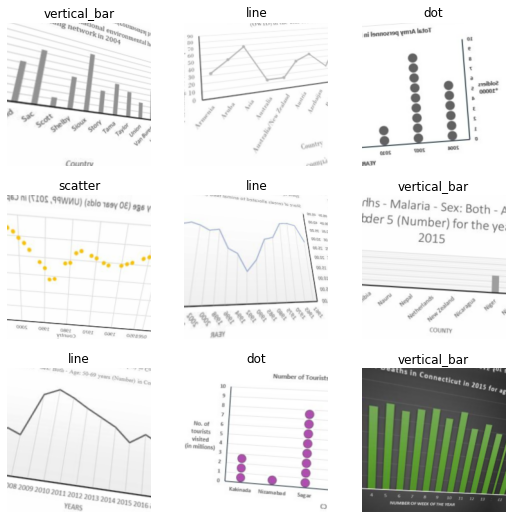

In [14]:
#dls = graphs.dataloaders(working_df.sample(10000))
dls = graphs.dataloaders(working_df)
dls.show_batch()

In [15]:
len(dls.train), len(dls.valid), len(final_df)

(757, 190, 60578)

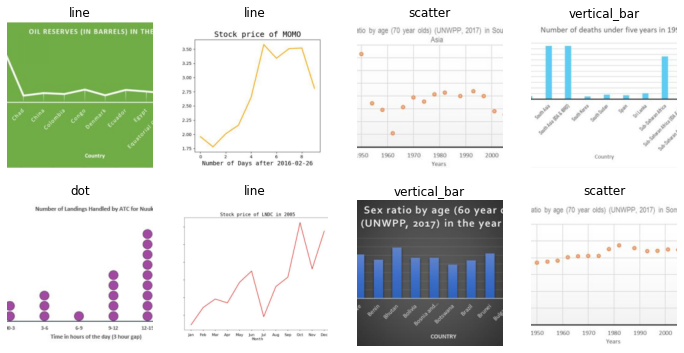

In [16]:
dls.valid.show_batch(max_n=8, nrows=2)

## Now start training

In [17]:
print(torch.cuda.is_available())

True


In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.047458,0.018355,0.005283,03:40


epoch,train_loss,valid_loss,error_rate,time
0,0.019174,0.026141,0.004870,04:58
1,0.017456,0.012363,0.002394,04:57
2,0.007202,0.009734,0.001733,04:58
3,0.006241,0.010005,0.001568,04:57


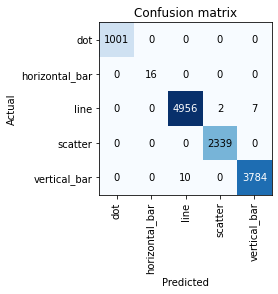

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

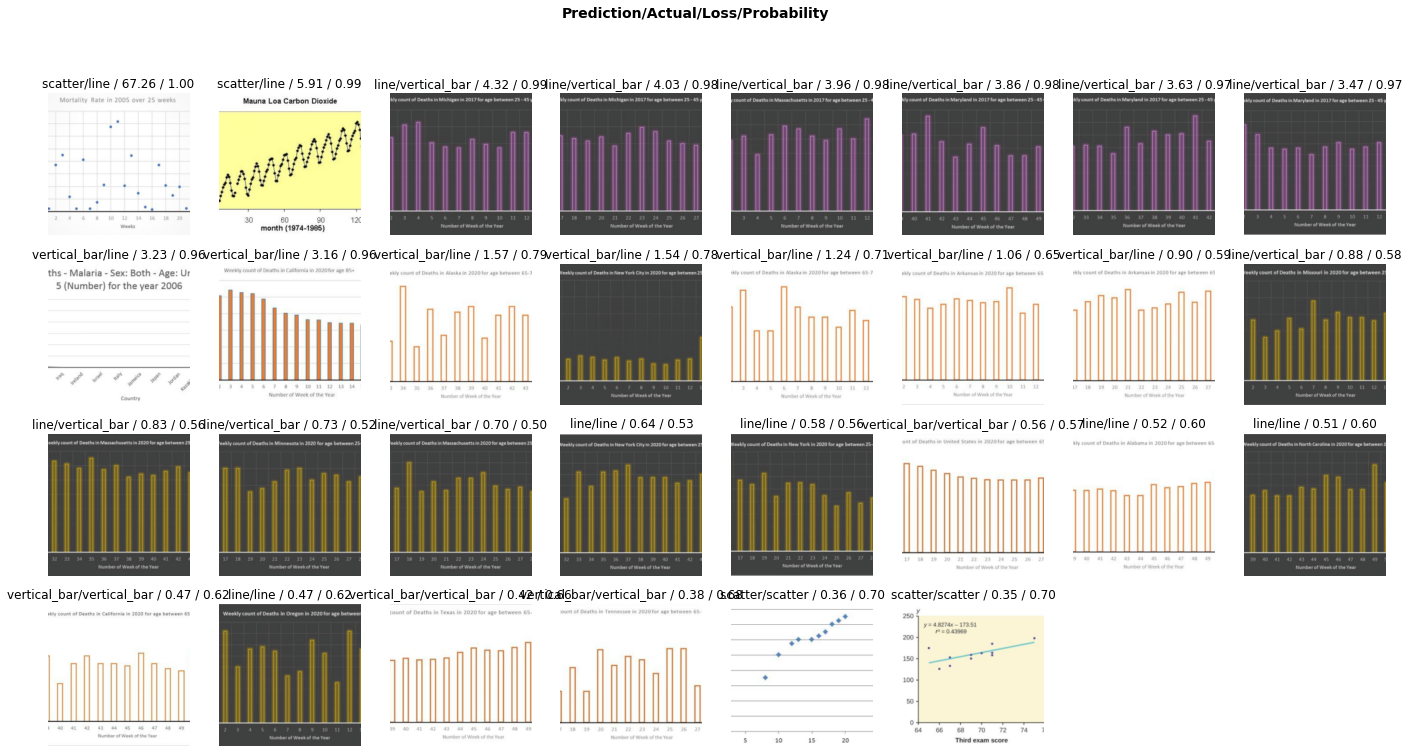

In [26]:
interp.plot_top_losses(30, nrows=4)

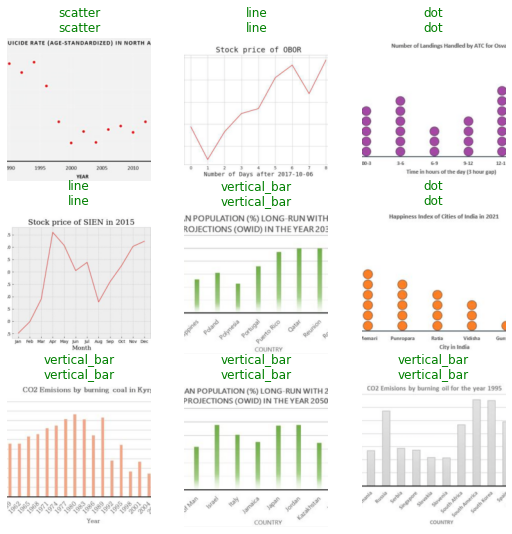

In [25]:
learn.show_results()